# Evaluating Uncertainty in Earthquake-Location Estimates for Groningen Seismicity

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#load in the data

# data1 = np.fromfile("borehole_Pwave_log.bin", dtype=np.float64)
# data2 = np.fromfile("borehole_Swave_log.bin", dtype=np.float64)
# data3 = np.fromfile("groningen_model_Pvelocity.bin", dtype=np.float64)
# data4 = np.fromfile("groningen_model_Svelocity.bin", dtype=np.float64)
# data5 = np.fromfile("shot_base_p_source_at_5001_and_rvz.bin", dtype=np.float64)
# data6 = np.fromfile("shot_base_s_source_at_5001_and_rvx.bin", dtype=np.float64)
# data7 = np.fromfile("shot_monitor_p_source_at_5001_and_rvz.bin", dtype=np.float64)
# data8 = np.fromfile("shot_monitor_s_source_at_5001_and_rvx.bin", dtype=np.float64)


## General

In [4]:
#define the time sampling and total recording time of seismic data
dt = 0.002  # s
tmax = 7.9  # s
nt = int(tmax/dt) + 1   # IMPORTANT: inclusive end time -> 3951
t = np.arange(nt)*dt

#sampling frequency
f_s = 1 / dt
f_n = f_s / 2

#defines the positions of the receviers
dx_rec = 2.5
x_rec = np.arange(2000.0, 8000.0 + dx_rec/2, dx_rec)
nx = x_rec.size
x_src = 5001.0

dz = 1.25  # log/model depth sampling

#centre freq
f_centre = 40 #Hz


## Task 1: load in the data and show the gathers



In [5]:
#function to read the binary file
def read_gather(path, nt=nt, nx=nx, dtype=np.float32):
    tmp = np.fromfile(path, dtype=dtype)
    if tmp.size != nt*nx:
        raise ValueError(f"{path}: expected {nt*nx}, got {tmp.size}")
    # IMPORTANT: data is trace-major → Fortran order
    return np.reshape(tmp, (nt, nx), order='F')


def read_1d(path, n, dtype=np.float32):
    a = np.fromfile(path, dtype=dtype)
    if a.size != n:
        raise ValueError(f"{path}: expected {n}, got {a.size}")
    return a

#shows a seismic gather as an image, time vertically and recevier point horizontally
def show_gather(g, title, clip=99.5):
    # Amplitude clipping for display
    lim = np.percentile(np.abs(g), clip)

    # Define physical axes
    extent = [
        np.min(x_rec),           # receiverPositions min
        np.max(x_rec),           # receiverPositions max
        np.max(t),               # timeSamples max (bottom)
        np.min(t)                # timeSamples min (top)
    ]

    plt.figure(figsize=(10,5))
    plt.imshow(
        g,
        cmap="gray",
        aspect="auto",
        extent=extent,
        vmin=-lim,
        vmax=lim
    )
    plt.xlabel("Receiver position (m)")
    plt.ylabel("Time (s)")
    plt.title(title)
    plt.show()


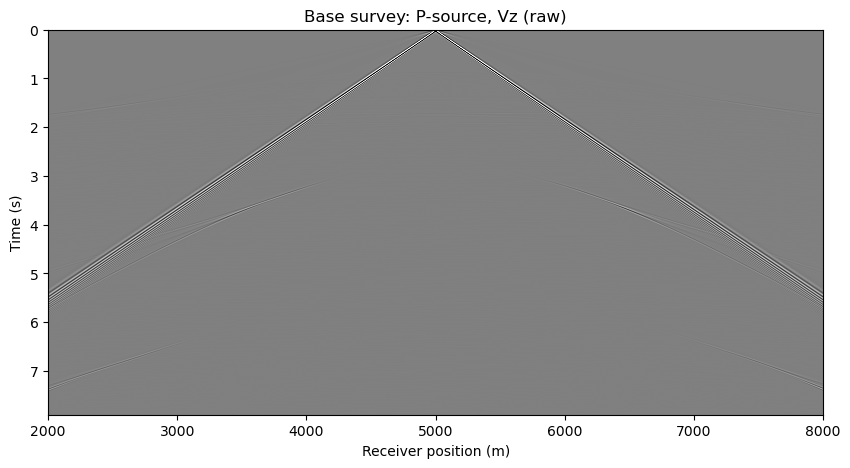

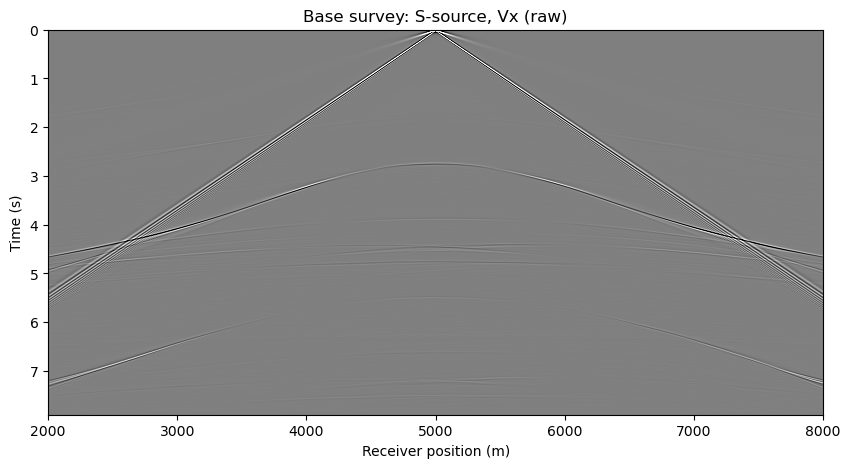

In [6]:
gP_base = read_gather("shot_base_p_source_at_5001_and_rvz.bin")
gS_base = read_gather("shot_base_s_source_at_5001_and_rvx.bin")
gP_mon  = read_gather("shot_monitor_p_source_at_5001_and_rvz.bin")
gS_mon  = read_gather("shot_monitor_s_source_at_5001_and_rvx.bin")

vp_log = read_1d("borehole_Pwave_log.bin", n=3600)
vs_log = read_1d("borehole_Swave_log.bin", n=3600)


#these are the two graphs also seen in the assignment, so the data is correctly imported and reshaped
show_gather(gP_base, "Base survey: P-source, Vz (raw)")
show_gather(gS_base, "Base survey: S-source, Vx (raw)")


## Task 2: supression of the surface waves

In [7]:
def fk_surface_wave_suppression_notebook_style(
    reflectionData,
    dt,
    dx,
    vmin,
    fmax=120.0,
    taper=0.15,
    plot_fk=True,
    plot_mask=True
):
    """
    Surface-wave suppression using f-k filtering.

    Parameters
    ----------
    reflectionData : 2D array (nt, nx)
        Seismic gather in time-space domain.
    dt : float
        Time sampling (s).
    dx : float
        Receiver spacing (m).
    vmin : float
        Minimum apparent velocity to preserve (m/s).
    fmax : float
        Maximum frequency to preserve (Hz).
    taper : float
        Relative width of the taper around vmin.
    plot_fk : bool
        Plot magnitude of the f-k spectrum.
    plot_mask : bool
        Plot the f-k mask.
    """

    # ----------------------------------
    # Step 1: FFT to f-k domain
    # ----------------------------------
    nt, nx = reflectionData.shape

    FK = np.fft.fft2(reflectionData)
    FKsh = np.fft.fftshift(FK)

    f = np.fft.fftshift(np.fft.fftfreq(nt, d=dt))   # Hz
    k = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))   # cycles/m

    # ----------------------------------
    # Step 2: Apparent velocity calculation
    # ----------------------------------
    w = 2*np.pi*f[:, None]         # rad/s
    kr = 2*np.pi*k[None, :]        # rad/m

    eps = 1e-12
    vapp = np.abs(w) / (np.abs(kr) + eps)

    # ----------------------------------
    # Step 3: Build the mask
    # ----------------------------------
    bandMask = (np.abs(f) <= fmax)[:, None]

    #Ramp the filter (linearly in this case) in order to avoid a sharp cut-off
    v0 = vmin*(1 - taper)
    v1 = vmin*(1 + taper)

    ramp = np.clip((vapp - v0) / (v1 - v0 + eps), 0, 1)

    mask = ramp * bandMask

    # ----------------------------------
    # Step 4: Plot f-k spectrum (optional)
    # ----------------------------------
    # if plot_fk:
    #     extent_fk = [k[0], k[-1], f[-1], f[0]]

    #     plt.figure(figsize=(14,6))
    #     plt.imshow(
    #         np.log10(np.abs(FKsh) + 1e-12),
    #         aspect="auto",
    #         extent=extent_fk
    #     )
    #     plt.title("Common-source gather in f–k domain (log amplitude)")
    #     plt.xlabel("Wavenumber k (cycles/m)")
    #     plt.ylabel("Frequency f (Hz)")
    #     plt.colorbar(label="log10 |G(f,k)|")
    #     plt.show()

    # ----------------------------------
    # Step 5: Plot the mask (optional)
    # # ----------------------------------
    # if plot_mask:
    #     extent_mask = [k[0], k[-1], f[-1], f[0]]

    #     plt.figure(figsize=(14,6))
    #     plt.imshow(
    #         mask,
    #         aspect="auto",
    #         extent=extent_mask,
    #         vmin=0,
    #         vmax=1
    #     )
    #     plt.title("f–k mask (0 = removed, 1 = preserved)")
    #     plt.xlabel("Wavenumber k (cycles/m)")
    #     plt.ylabel("Frequency f (Hz)")
    #     plt.colorbar(label="Mask value")
    #     plt.show()

    # ----------------------------------
    # Step 6: Apply mask and inverse FFT
    # ----------------------------------
    FKf = FKsh * mask
    FKf = np.fft.ifftshift(FKf)

    filteredData = np.real(np.fft.ifft2(FKf))

    return filteredData, mask, f, k


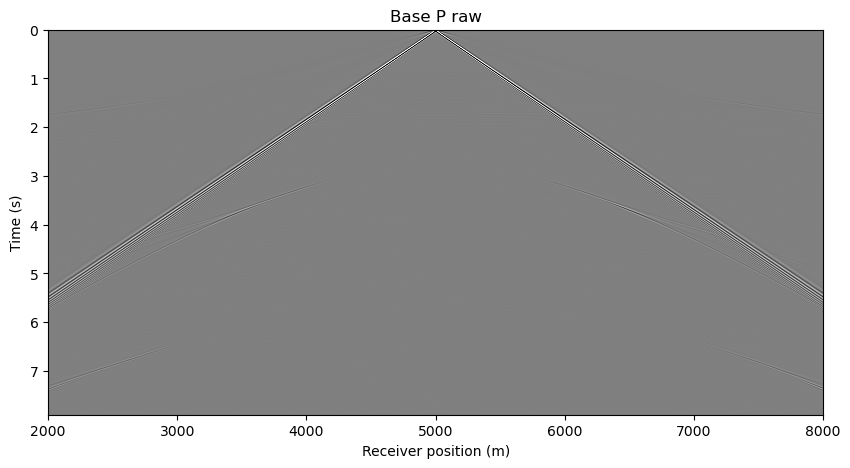

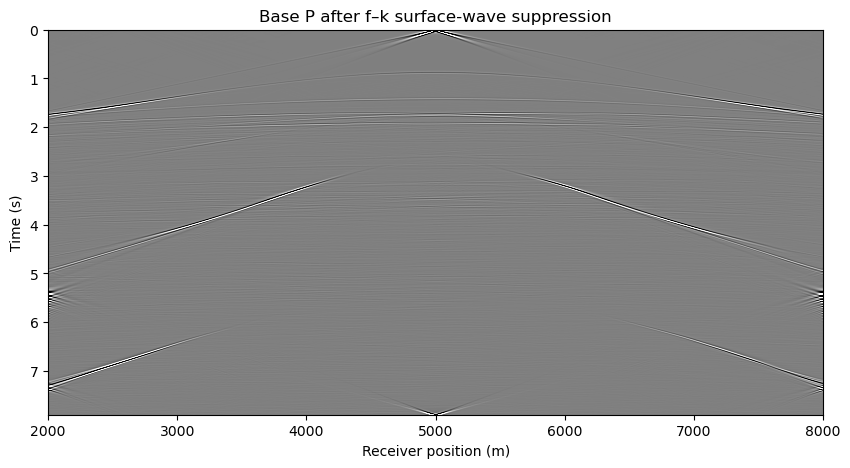

In [8]:
#suppression of the p-waves
gP_base_f, maskP, fP, kP = fk_surface_wave_suppression_notebook_style(
    gP_base,
    dt,
    dx_rec,
    vmin=1200,
    fmax=120,
    plot_fk=True,
    plot_mask=True
)

show_gather(gP_base,   "Base P raw")
show_gather(gP_base_f, "Base P after f–k surface-wave suppression")


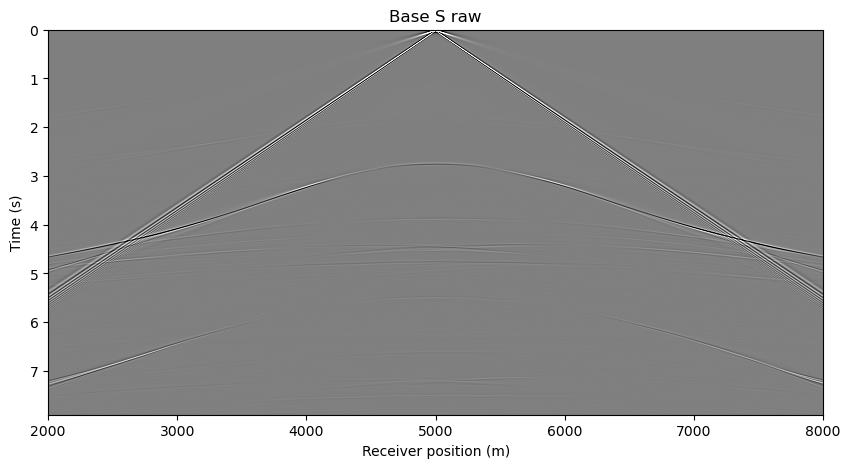

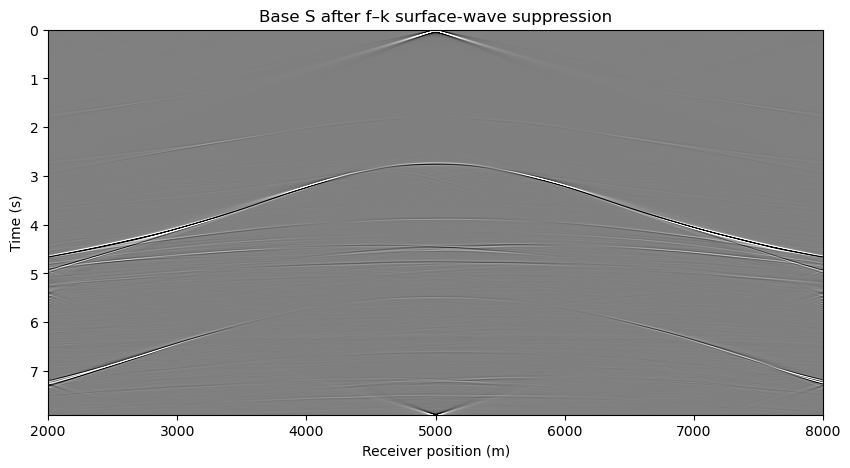

In [9]:
#supression of the s-waves
gS_base_f, maskS, fS, kS = fk_surface_wave_suppression_notebook_style(
    gS_base,
    dt,
    dx_rec,
    vmin=1100,
    fmax=120,
    plot_fk=True,
    plot_mask=True
)

show_gather(gS_base,   "Base S raw")
show_gather(gS_base_f, "Base S after f–k surface-wave suppression")



For determination of the maximum frequency that we want to preserve, the centre frequency is used. A typical seismic source (Ricker wavelet), most of the energy is concentrated around the centre frequency. A ricker Wavelet with centre frequency $f_0$ has strong spectral content from 0 to 3 * $f_0$. With $f_0$ = 40 Hz, the $f_{max}$ = 120 Hz. Since this is well below the Nyquist frequency, no aliasing should occur.

The filter is applied in the f-k domain, because different wave types separate by apparent velocity in that domain. In the f-x domain, the different wave types do not separate cleanly. This would result in either failure of applying the filter or removing useful data.
- Surface waves are slow and have a different apparant velocity. Surface waves have a low apparant velocity.
- Reflection waves are faster and have a hyperbolic shape. Reflection waves have a high apparant velocity.

The waves are separated based on their difference in apparant velocity in the f-k domain, which can be seen as a clear separation of energy in the f-k domain. 

Based on the figure the velocity of the surfacewaves is computed by using: V = S/ (TWT/2). This results in a velocity of give or take 1100 m/s

## Task 3: analysing the common-source gathers and show the reflections

The vertical resolution in seismics is approximated by:

$$
\Delta z \approx \frac{\lambda}{4} = \frac{v}{4f}
$$

where the wavelength is given by
$$
\lambda = \frac{v}{f}.
$$

Abrupt changes or jumps in the velocity profile occur at the following depths:

General:
- f = 40 Hz, which is the centre frequency

P-wave velocity profile:
- 800 m, with v = 2500 m/s
- 1700 m, with v = 4500 m/s
- 1900 m, with v = 4400 m/s
- 2200 m, with v = 6000 m/s
- 2900 m , with v = 6000 m/s

S-wave velocity profile: 
- 800 m, with v = 1200 m/s
- 1700 m, with v = 2400 m/s
- 1900 m, with v = 2500 m/s
- 2200 m, with v = 3500 m/s
- 2900 m, with v = 3500 m/s

Calculation of the required vertical resolution:
- The maximum speed of P-waves is determined at 6000 m/s
- The maximum speed of S-waves is determined at 3500 m/s

As velocity varies with depth, the vertical resolution is depth dependent. However, using the maximum velocity in the model provides a conservative upper bound on the minimum resolvable layer thickness. Interfaces separated by more than this bound are therefore resolvable.

This means that the vertical resolution for P-waves, based on the maximum velocity, is:
$$
\Delta z_p \approx \frac{\lambda}{4} = \frac{v}{4f} = \frac{6000}{4 * 40} = 37.5 m
$$
And for S-waves:
$$
\Delta z_s \approx \frac{\lambda}{4} = \frac{v}{4f} = \frac{3500}{4 * 40} = 21.875 m
$$

At high P-wave velocities (up to 6000 m/s), the wavelength at the centre frequency
of 40 Hz becomes large (λ ≈ 150 m), resulting in a vertical resolution of
approximately 37.5 m. This limits the ability to resolve thin layers or closely
spaced interfaces using P-wave data.


In [10]:
def twt_vrms(v, dz=1.25):
    dt_ow = dz / v #delta_z/v
    t_ow  = np.cumsum(dt_ow) #one-way travel time
    twt   = 2 * t_ow #two-way travel time
    vrms  = np.sqrt(np.cumsum((v**2) * dt_ow) / (np.cumsum(dt_ow) + 1e-12)) #compute the RMS velocity to predict moveout
    return twt, vrms

# --- 2) Reflection hyperbola ---
def hyperbola(t0, vrms, x_rec, x_src):
    off = np.abs(x_rec - x_src)
    return np.sqrt(t0**2 + (off/vrms)**2) #Predicts how a reflection wave looks in a common-source gather

twtP, vrmsP = twt_vrms(vp_log)
twtS, vrmsS = twt_vrms(vs_log)

def twt_from_vp_log(vp_log, dz=1.25):
    """
    Compute one-way and two-way travel time from a velocity log.

    Parameters
    ----------
    vp_log : 1D array
        P-wave velocity as function of depth (m/s)
    dz : float
        Depth sampling (m)

    Returns
    -------
    z : 1D array
        Depth (m)
    t1w : 1D array
        One-way travel time (s)
    twt : 1D array
        Two-way travel time (s)
    """
    z = np.arange(len(vp_log)) * dz
    t1w = np.cumsum(dz / vp_log)
    t1w = np.insert(t1w[:-1], 0, 0.0)   # t=0 at surface
    twt = 2.0 * t1w
    return z, t1w, twt

twt_old, _ = twt_vrms(vp_log)
z, tw1, twt_new = twt_from_vp_log(vp_log)

# print(1.25 / vp_log)

# plt.figure()
# plt.plot(twt_new, -z, color='blue')
# for i in range(len(depthsP)):
#     plt.axhline(-depthsP[i], color='red', lw=1.8, linestyle='--')

Candidate reflector depths (P-log):
812 m
1698 m
1893 m
2153 m
2195 m
2808 m
2858 m
3127 m


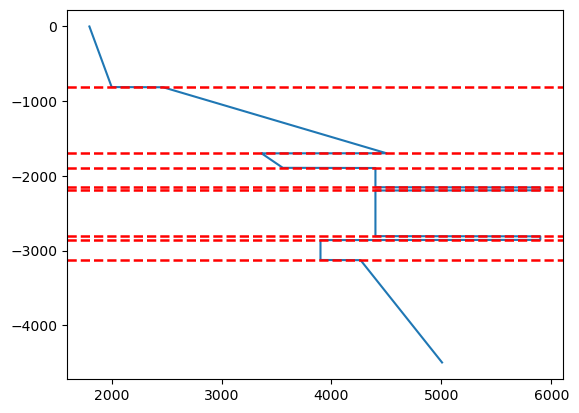

In [11]:
#second iteration of how to do this. I like this one better because it is easier to follow and also shows the depths at which the velocities jump in the profile.
#was nto able to resolve the labelling of the different lines (which belongs to which)

def find_velocity_jumps(v, dz, dv_threshold):
    """
    Find indices where |dv| exceeds a threshold.
    Returns depth indices.
    """
    dv = np.abs(np.diff(v))
    idx = np.where(dv > dv_threshold)[0] + 1
    depths = idx * dz
    return idx, depths

# Detect all velocity jumps (P-wave example)
idxP, depthsP = find_velocity_jumps(vp_log, dz, dv_threshold=100)

print("Candidate reflector depths (P-log):")
for d in depthsP:
    print(f"{int(d)} m")

plt.plot(vp_log, -z)
for i in range(len(depthsP)):
    plt.axhline(-depthsP[i], color='red', lw=1.8, linestyle='--')

All major velocity contrasts from the borehole logs were initially used to
predict reflection arrival times and overlaid on the common-source gathers.
However, due to the vertical resolution limit (Δz ≈ λ/4), not all interfaces
can be expected to generate separate, observable reflections. In particular,
for P-waves at high velocities (v ≈ 6000 m/s), the vertical resolution is
approximately 37.5 m. Consequently, only interfaces that produce clear,
continuous reflection events in the seismic data were retained for final
labelling. This means that each peak was kept, as they all fit within the vertical resolution of the reflected P-waves, which is the critical vertical resolution.


Waves that are flatter, more horizontal line like, travel faster, thus they will be P-waves. Waves that are first parabolic and then flatten when going away from the receiver position are S-waves.

A key takeaway is that: you may predict many reflectors from the velocity log, but the seismic data decides which ones are actually visible — and vertical resolution explains why.

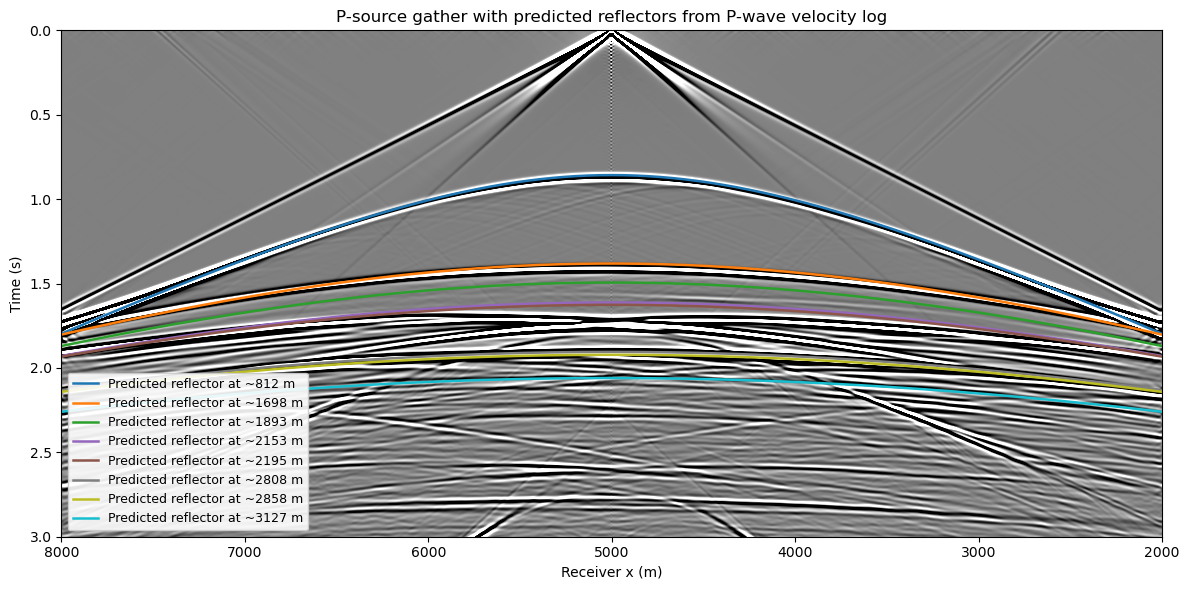

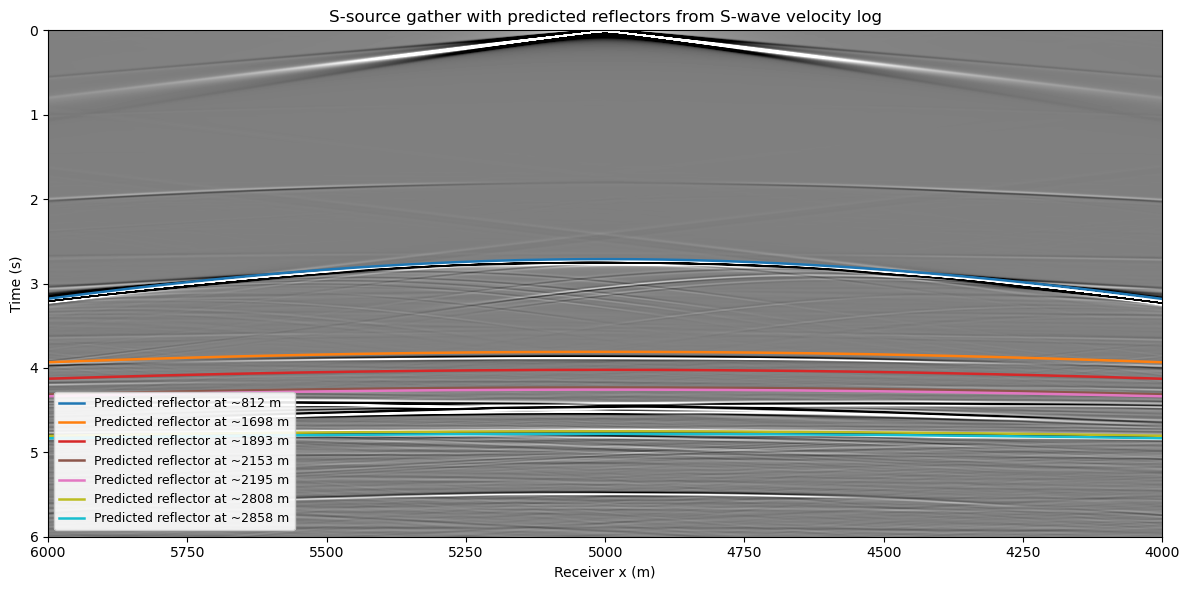

In [12]:
#with a little help from chat the labelling is fixed

#Ik zou deze als eerste neerzetten om te laten zien welke lijnen er allemaal geidentificeerd worden. Daarna dan een selectie maken op verschil in golflengte
#Ik had er moeite mee te kiezen welke nou allemaal een duidelijk signaal zijn, met name door de verschillende snelheden die worden gegeven.
#Na dit opnieuw gelezen te hebben lijkt het mij erg logisch om de verticale resolutie te bepalen adhv de maximale snelheid, geeft de grootste verticale resolutie, 
# en in theorie zouden dan meer pieken af moeten vallen, maar alles valt erbinnen... beetje gekkig.

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_all_candidate_reflectors_with_legend(
    g, twt, vrms, idx, depths, title, y_lim, x_lim, clip
):
    lim = np.percentile(np.abs(g), clip)
    extent = [np.min(x_rec), np.max(x_rec), np.max(t), np.min(t)]

    plt.figure(figsize=(12,6))
    plt.imshow(
        g,
        cmap="gray",
        aspect="auto",
        extent=extent,
        vmin=-lim,
        vmax=lim
    )
    plt.xlabel("Receiver x (m)")
    plt.ylabel("Time (s)")
    plt.title(title)

    # Create a color map for unique reflector colours
    colors = cm.tab10(np.linspace(0, 1, len(depths)))

    lines = []
    labels = []

    for i, d, c in zip(idx, depths, colors):
        curve = hyperbola(twt[i], vrms[i], x_rec, x_src)
        # plt.axhline(twt[i], color=c, lw=1.8, linestyle='--', label=f"Predicted reflector at ~{int(d)} m")
        # plt.text(
        #     0.99, twt[i],
        #     f"~{int(d)} m",
        #     color=c,
        #     fontsize=9,
        #     va='bottom',
        #     ha='right',
        #     transform=plt.gca().get_yaxis_transform()
        # )
        line, = plt.plot(x_rec, curve, color=c, lw=1.8)
        lines.append(line)
        labels.append(f"Predicted reflector at ~{int(d)} m")

    plt.ylim(y_lim[1], y_lim[0])
    plt.xlim(x_lim[1], x_lim[0])

    # Add legend
    plt.legend(
        lines,
        labels,
        loc="lower left",
        fontsize=9,
        framealpha=0.9
    )

    plt.tight_layout()
    plt.show()

# P-wave candidates
idxP, depthsP = find_velocity_jumps(vp_log, dz, dv_threshold=300)

plot_all_candidate_reflectors_with_legend(
    gP_base_f,
    twtP,
    vrmsP,
    idxP,
    depthsP,
    "P-source gather with predicted reflectors from P-wave velocity log",
    y_lim=[0, 3],
    x_lim = [2000, 8000],
    clip = 90
)

# S-wave candidates
idxS, depthsS = find_velocity_jumps(vs_log, dz, dv_threshold=200)

plot_all_candidate_reflectors_with_legend(
    gS_base_f,
    twtS,
    vrmsS,
    idxS,
    depthsS,
    "S-source gather with predicted reflectors from S-wave velocity log",
    y_lim = [0, 6], 
    x_lim = [4000, 6000],
    clip = 97
)


It can be seen in these plots that the reflections from the S-waves arrive much later than P-wave refelections, which is logical because P-waves travel faster than S-waves. 

## Task 4: Detecting velocity changes

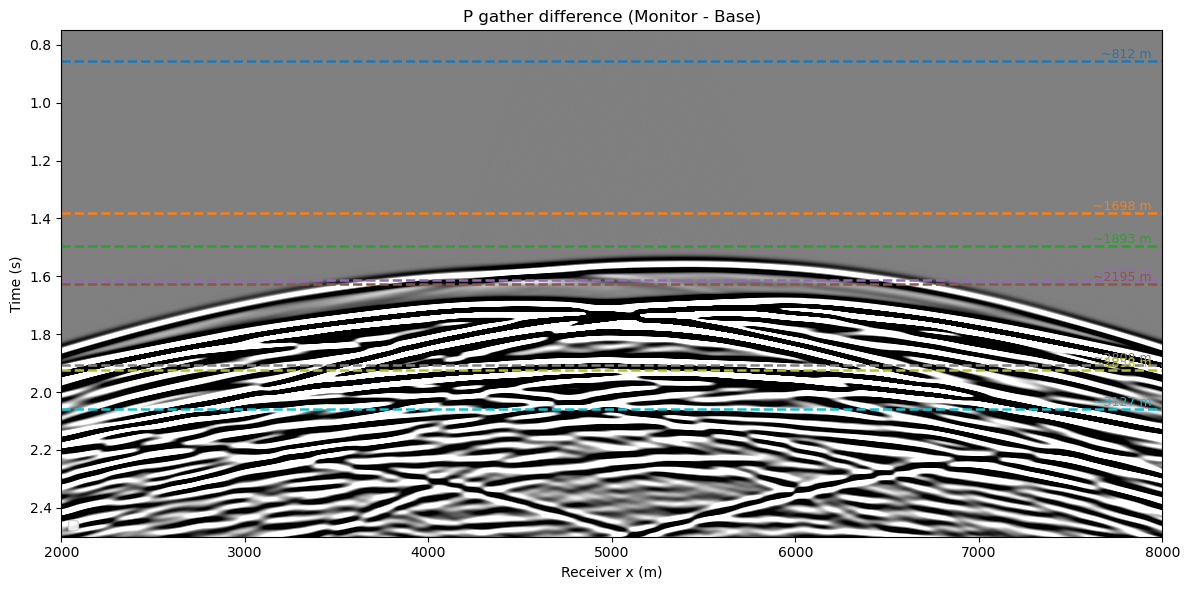

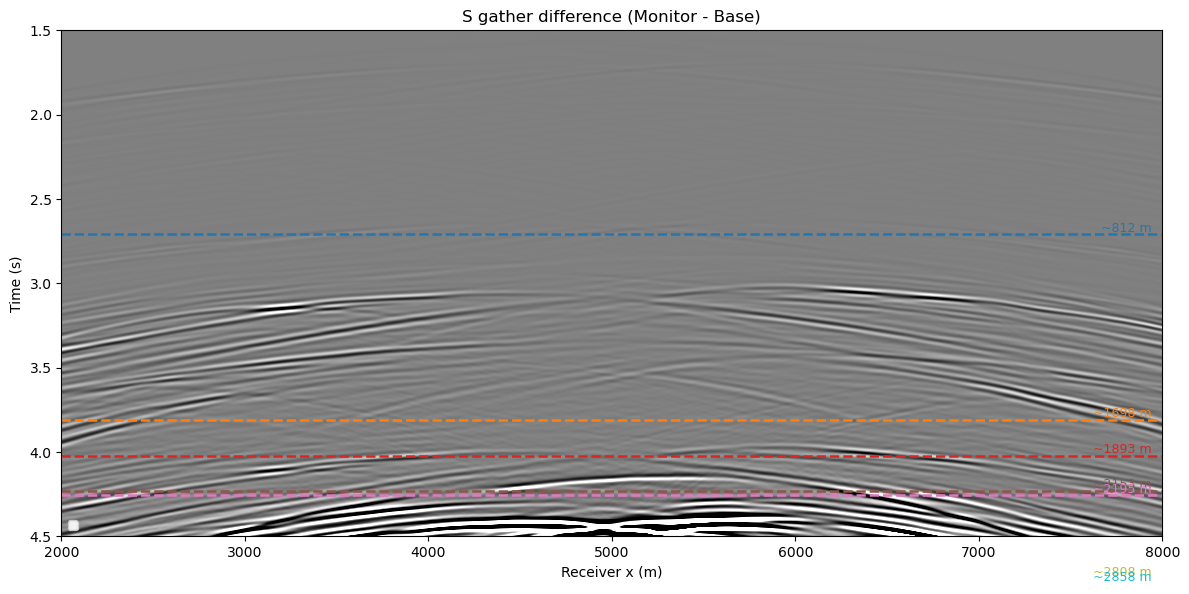

In [13]:
# I want to try and overlay the two different common-source gatehrs and literally check where the differences are. 
# Per timestep, the differences should be saved as a group. If a difference is apparant then it should be marked. 
# with the time known, and the velocity known from the velocity profile, the depth at which a change occurs should be resolved. (time->space)

# The next is to calculate the difference in velocity. THis can be done with the use of the time shift that has occured and assuming that the change only occurs in one layer
# the idea is that the layer above should have no time shift, whilst the layer below has a constant timeshift.
# now the difference in layer thicknesss can be calulated (h=z1-z2)
# calculate base two-way time (t0 = 2h/v0); v0 from velocity profile
# now v1=1/((1/v0)+(delta_t/2h))



def difference_gather(base, mon, title, idx, depths, twt, vrms, y_lim, clip=80):
    """Plot delta = monitor - base."""
    dg = mon - base
    lim = np.percentile(np.abs(dg), clip)
    extent = [np.min(x_rec), np.max(x_rec), np.max(t), np.min(t)]
    plt.figure(figsize=(12,6))
    plt.imshow(dg, cmap="gray", aspect="auto", extent=extent, vmin=-lim, vmax=lim)

    colors = cm.tab10(np.linspace(0, 1, len(depths)))

    lines = []
    labels = []

    for i, d, c in zip(idx, depths, colors):
        plt.axhline(twt[i], color=c, lw=1.8, linestyle='--')
        #lines.append(line)
        plt.text(
            0.99, twt[i],
            f"~{int(d)} m",
            color=c,
            fontsize=9,
            va='bottom',
            ha='right',
            transform=plt.gca().get_yaxis_transform()
        )
        labels.append(f"Predicted reflector at ~{int(d)} m")

    plt.xlabel("Receiver x (m)")
    plt.ylabel("Time (s)")
    plt.ylim(y_lim[1], y_lim[0])
    plt.title(title + " (Monitor - Base)")
    plt.legend(
        lines,
        labels,
        loc="lower left",
        fontsize=9,
        framealpha=0.9
    )
    plt.tight_layout()
    plt.show()
    return dg

# ---------- run for P and S ----------
# (Optionally use filtered gathers gP_base_f, gP_mon_f, etc. if you already made them.)
P_base = gP_base
P_mon  = gP_mon
S_base = gS_base
S_mon  = gS_mon

idxP, depthsP = find_velocity_jumps(vp_log, dz, dv_threshold=300)
idxS, depthsS = find_velocity_jumps(vs_log, dz, dv_threshold=200)

# 2) Difference gathers
dP = difference_gather(P_base, P_mon, "P gather difference", idxP, depthsP, twtP, vrmsP, y_lim=[0.75,2.5], clip=70)
dS = difference_gather(S_base, S_mon, "S gather difference", idxS, depthsS, twtS, vrmsS, y_lim=[1.5,4.5], clip=95)

    


Velocity changes were detected between base and monitoring survey by calculating and plotting the difference between the base and common source gathers (unfiltered, as surface waves are the same for both they automatically fall away). To match the changes to the layers, we overlayed the layers on the graph showing differences, and scaled y-limit of the graph to the first observerd differences. After the first differences, we can observe visually that at what layer the this occurs. This can be best done using the P-wave difference plot. The P-wave difference plot shows a single clear event because the Vz data is dominated by coherent P-wave arrivals that largely cancel during subtraction, except where the velocity change affects travel times. The S-wave difference plot appears noisier because S-waves are slower and more sensitive to velocity changes, and the Vx component contains more complex wavefield energy that does not cancel perfectly. The clear difference in the P-wave difference plot is observed at aproximately the 3rd line (at +- 1893 m), which corresponds with the 4th layer. 

# Task 5

To estimate the difference in velocity of the changed layer (layer 4), we will visually observe the difference in the base and monitor plots. The difference in two-way travel time at which a certain reflection is observed will be used to estimate the velocity difference. This should ideally be the reflection at the bottom of the 4th layer, where all of the difference in two way travel time can be attributed to the change in velocity in the 4th layer. This is done below, first for the P-waves, and then for the S-waves.

In [14]:
def plot_base_monitor_side_by_side(
    g_base, g_mon, t, x_rec, t_pick,
    y_lim=(0.0, 3.0), x_lim=(2000, 8000),
    clip=95,
    cmap="gray",
    title_base="Base",
    title_mon="Monitor",
):
    # consistent amplitude scaling for fair comparison
    lim = max(np.percentile(np.abs(g_base), clip),
              np.percentile(np.abs(g_mon),  clip))

    extent = [np.min(x_rec), np.max(x_rec), np.max(t), np.min(t)]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # time/depth for chosen reflector
    for ax, g, ttl in zip(axes, [g_base, g_mon], [title_base, title_mon]):
        ax.imshow(g, cmap=cmap, aspect="auto", extent=extent, vmin=-lim, vmax=lim)
        ax.set_title(ttl)
        ax.set_xlabel("Receiver x (m)")
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[1], y_lim[0])  # invert y-axis

        # optional extra reference line
        for t in t_pick:
            ax.axhline(t, color="yellow", lw=1.5, linestyle="--")

    axes[0].set_ylabel("Time (s)")
    fig.suptitle("Base vs Monitor comparison", y=1.02, fontsize=14)

    plt.tight_layout()
    plt.show()


# P-waves

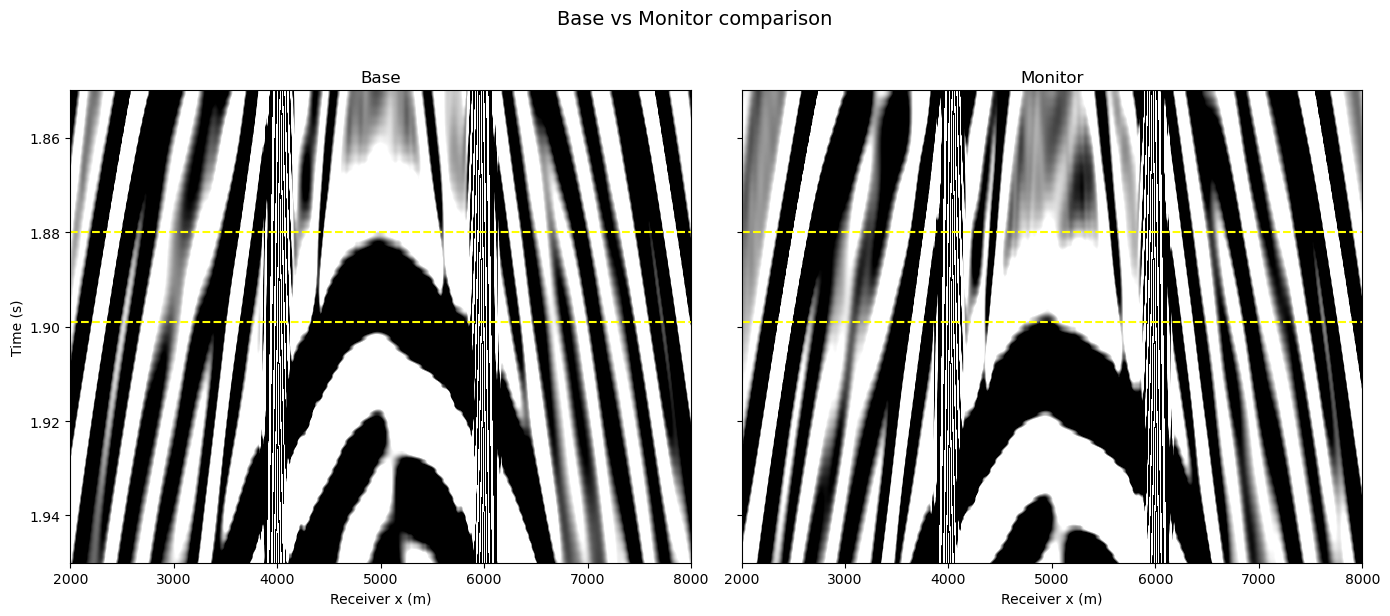

In [24]:
plot_base_monitor_side_by_side(
    g_base=gP_base,
    g_mon=gP_mon,        
    t=t,
    x_rec=x_rec,
    t_pick=[1.880, 1.899],
    y_lim=(1.85, 1.95),       
    clip=70,
)


Onfortunately, the bottom of the layer 4 can not be distinguished clear enough to say something about the two-way travel time difference due to the velocity change. Therefore we are using a reflection below this layer. As nothing else has changed, only the velocity in layer 4, the difference in two-way travel time observed in a reflection below layer 4 are still due to the velocity change in layer 4.  

A shift in two way travel time for the selected reflection, can be seen in the difference between the two yellow lines in the plots. These lines are indicated to be at t = 1.880 s and t = 1.899 s. The difference between the two is 0.019 seconds. This difference was determined visually, and there is thus a margin for error; especially with a difference as small as this.

The difference in velcoity can be calculated through: 

$$\Delta v = 2s / \Delta t$$

In which s is the size of the layer (layer 4 has size 2153 - 1893 = 260 m). This gives a total $$\Delta v = 2 * 260 / 0.19 = 2737 m/s$$  

# S-waves

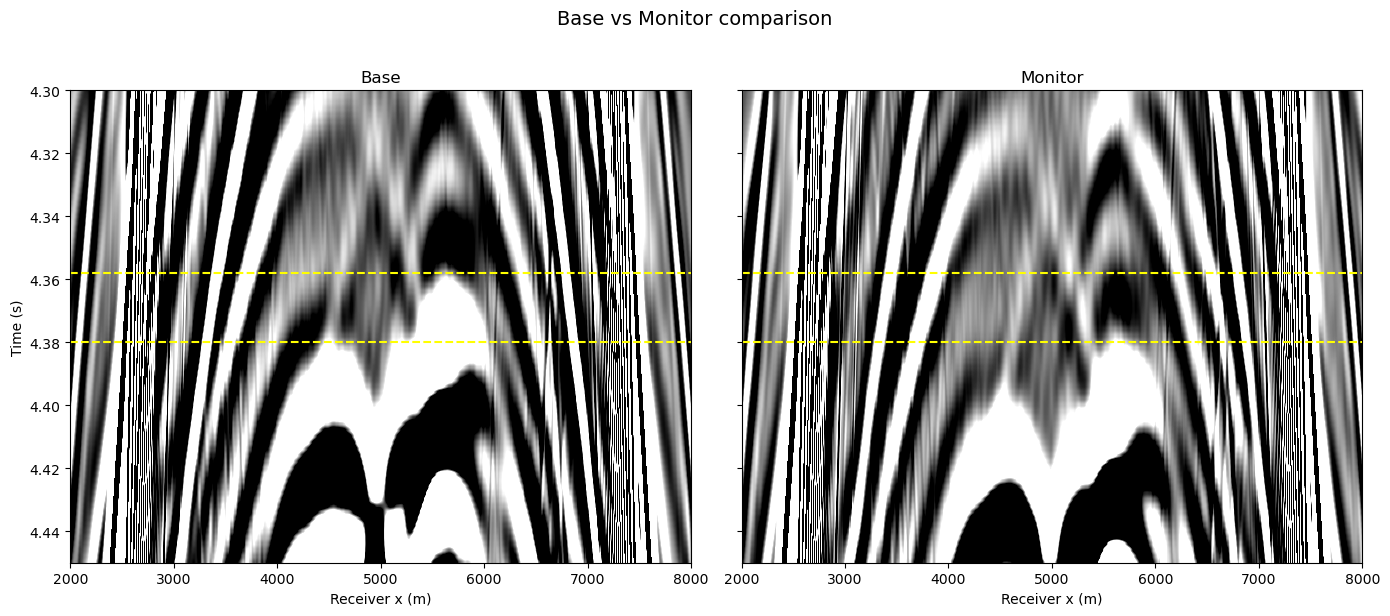

In [25]:
plot_base_monitor_side_by_side(
    g_base=gS_base,
    g_mon=gS_mon,        
    t=t,
    x_rec=x_rec,
    t_pick=[4.358, 4.38],
    y_lim=(4.3, 4.45),       
    clip=80,
)

As for the S-waves, a clear distinguishable reflection difference was found at a two way travel time of approximately 4.35 s. 

A shift in two way travel time for the selected reflection, can be seen in the difference between the two yellow lines in the plots. These lines are indicated to be at t = 4.358 s and t = 4.38 s. The difference between the two is 0.022 seconds. This difference was determined visually, and there is thus a margin for error; especially with a difference as small as this.

The difference in velcoity can be calculated through: 

$$\Delta v = 2s / \Delta t$$

In which s is the size of the layer (layer 4 has size 2153 - 1893 = 260 m). This gives a total $$\Delta v = 2 * 260 / 0.22 = 2363 m/s$$  

# Velocity difference plots

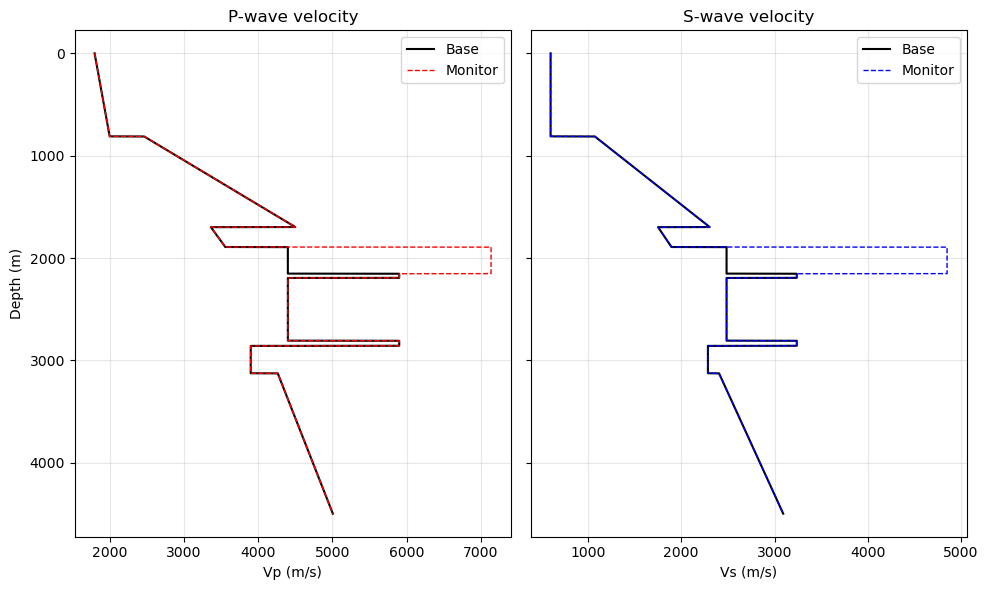

In [40]:
delta_vP_layer4 = 2737
delta_vS_layer4 = 2363

vp_log_monitor = vp_log.copy()
vp_log_monitor[idxP[2]:idxP[3]] += delta_vP_layer4

vs_log_monitor = vs_log.copy()
vs_log_monitor[idxS[2]:idxS[3]] += delta_vS_layer4

delta_vP_layer4 = 2737
delta_vS_layer4 = 2363

vp_log_monitor = vp_log.copy()
vp_log_monitor[idxP[2]:idxP[3]] += delta_vP_layer4

vs_log_monitor = vs_log.copy()
vs_log_monitor[idxS[2]:idxS[3]] += delta_vS_layer4

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

axes[0].plot(vp_log, z, label="Base", color="black")
axes[0].plot(vp_log_monitor, z, label="Monitor", color="red", linestyle="--", lw=1)
axes[0].set_xlabel("Vp (m/s)")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("P-wave velocity")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(vs_log, z, label="Base", color="black")
axes[1].plot(vs_log_monitor, z, label="Monitor", color="blue", linestyle="--", lw=1)
axes[1].invert_yaxis()
axes[1].set_xlabel("Vs (m/s)")
axes[1].set_title("S-wave velocity")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
